# Amazon.com - Employee Access Challenge

In [1]:
import pandas as pd
import numpy as np

amazon = pd.read_csv('train.csv')

In [2]:
amazon.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

In [3]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


## Data Description
<br>
<br>
ACTION - ACTION is 1 if the resource was approved, 0 if the resource was not
<br>
<br>
RESOURCE - An ID for each resource
<br>
<br>
MGR_ID - The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time
<br>
<br>
ROLE_ROLLUP_1 -Company role grouping category id 1 (e.g. US Engineering)
<br>
<br>
ROLE_ROLLUP_2 - Company role grouping category id 2 (e.g. US Retail)
<br>
<br>
ROLE_DEPTNAME - Company role department description (e.g. Retail)
<br>
<br>
ROLE_TITLE - Company role business title description (e.g. Senior Engineering Retail Manager)
<br>
<br>
ROLE_FAMILY_DESC - Company role family extended description (e.g. Retail Manager, Software Engineering)
<br>
<br>
ROLE_FAMILY - Company role family description (e.g. Retail Manager)
<br>
<br>
ROLE_CODE - Company role code; this code is unique to each role (e.g. Manager)

So, the objective is to predict approval/denial (ACTION) on the test set...

In [5]:
amazon.shape

(32769, 10)

In [6]:
amazon.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [7]:
amazon['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

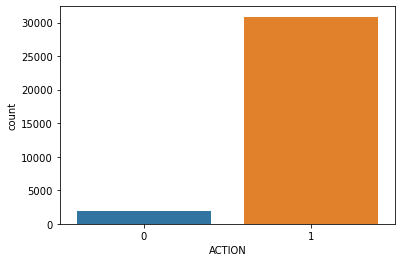

In [10]:
import seaborn as sns
import matplotlib as plt

sns.countplot(x='ACTION', data=amazon)

In [16]:
len(amazon['RESOURCE'].unique())

7518

In [11]:
amazon['RESOURCE'].value_counts()

4675     839
79092    484
25993    409
75078    409
3853     404
        ... 
35014      1
75535      1
30936      1
89856      1
16376      1
Name: RESOURCE, Length: 7518, dtype: int64

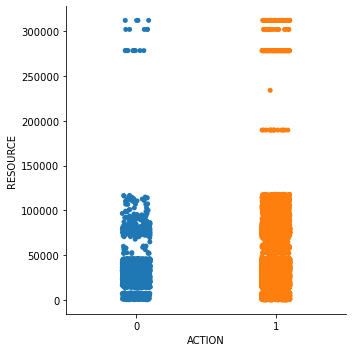

In [18]:
sns.catplot(x='ACTION', y='RESOURCE', data=amazon)

Boxplots can help us see the distributrion of each column

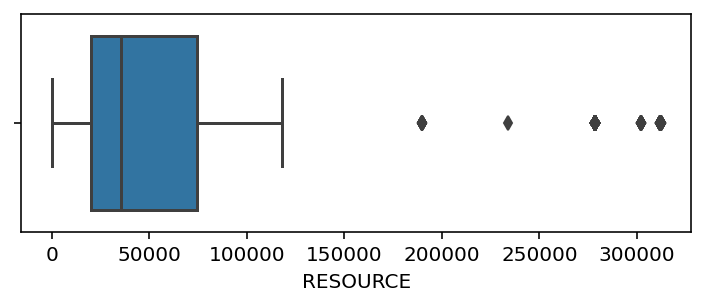

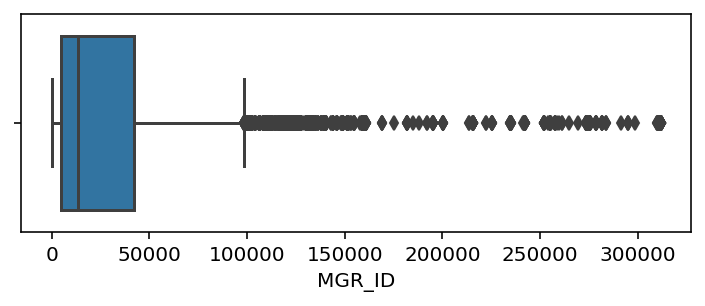

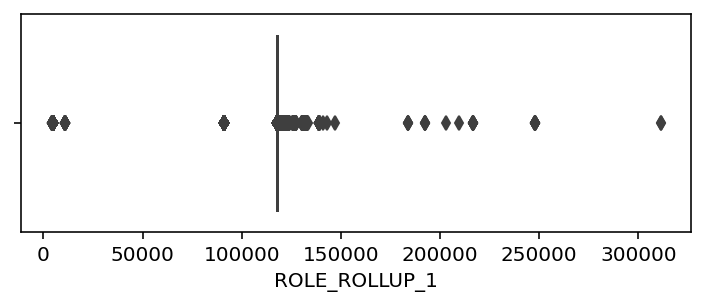

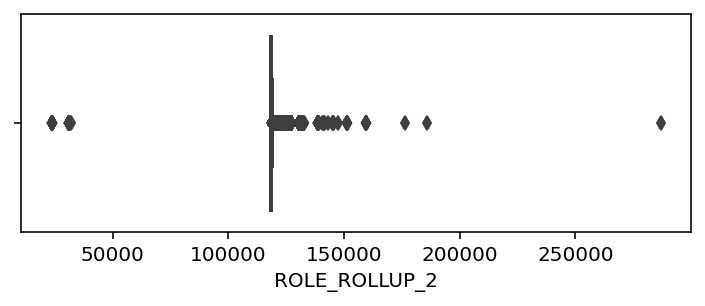

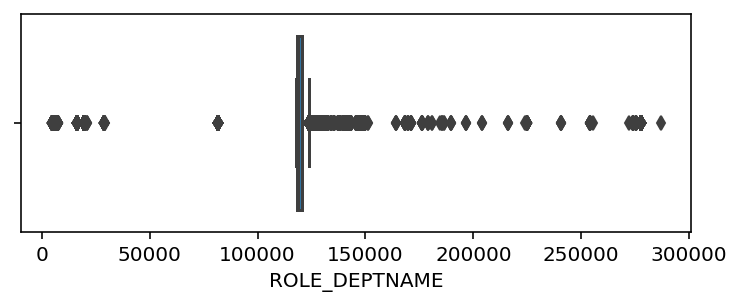

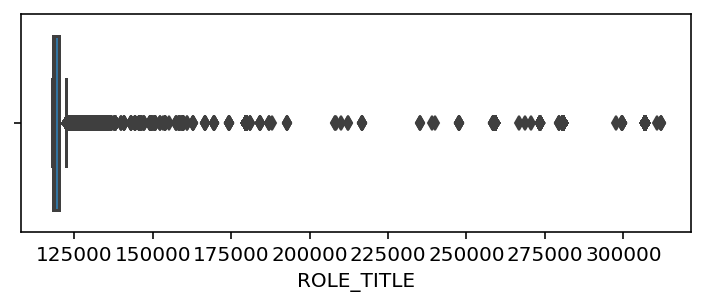

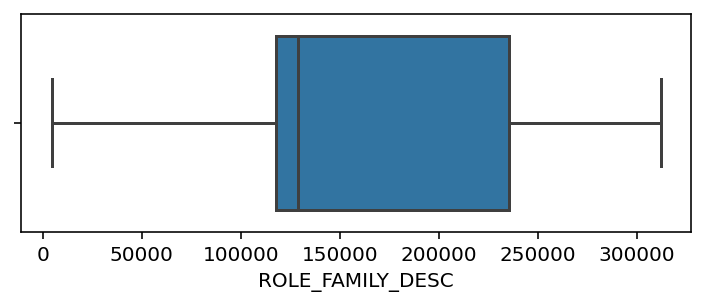

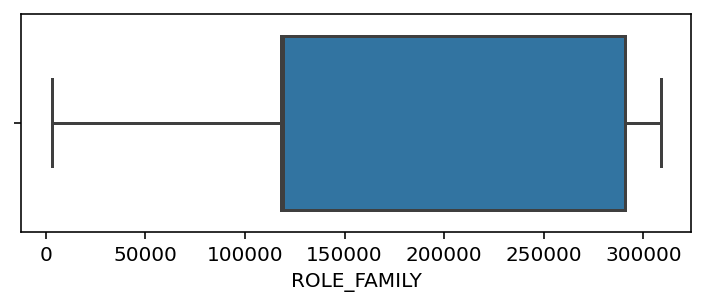

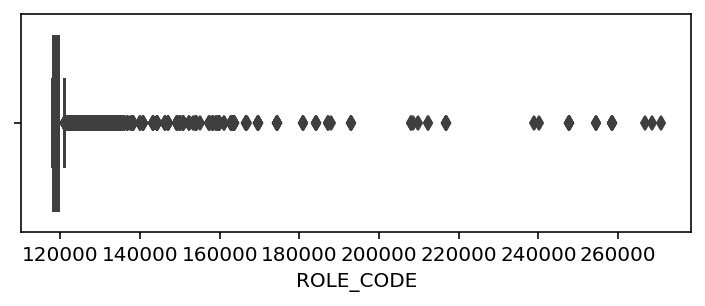

In [34]:
for i in amazon.columns.drop('ACTION'):
    plt.pyplot.figure(figsize=(6,2))
    sns.boxplot(amazon[i])

## Model Building

### Split Data

In [36]:
from sklearn.model_selection import train_test_split


X = amazon.drop('ACTION', axis=1)
y = amazon['ACTION']


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Logistic Regression

In [38]:
#no need to preprocess data w/ pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


log_reg = LogisticRegression(random_state=1)

log_reg.fit(X_train, y_train)

log_reg_preds = log_reg.predict(X_val)

print(classification_report(y_val,log_reg_preds))




precision    recall  f1-score   support

           0       0.00      0.00      0.00       353
           1       0.95      1.00      0.97      6201

    accuracy                           0.95      6554
   macro avg       0.47      0.50      0.49      6554
weighted avg       0.90      0.95      0.92      6554



95% overall accuracy, but that's only because it only correctly predicted resource granted 95% of the time. 0% accuracy on resource denial is not good...

## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_val)

print(classification_report(y_val, rf_preds))

precision    recall  f1-score   support

           0       0.56      0.39      0.45       353
           1       0.97      0.98      0.97      6201

    accuracy                           0.95      6554
   macro avg       0.76      0.68      0.71      6554
weighted avg       0.94      0.95      0.95      6554



## Random Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] 
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

               

In [41]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=1, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 61.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [42]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}